In [119]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

import networkx as nx
from networkx.algorithms import bipartite

import pycountry_convert

import matplotlib.pyplot as plt
import plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.io as pio

init_notebook_mode(connected=True)

# Data preparation

## Horizon Europe

In [120]:
he_projects = pd.read_csv('../data/raw/cordis-HORIZONprojects-csv/csv/project.csv', delimiter=';')
he_projects.head()

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi
0,101095387,AISym4MED,SIGNED,Synthetic and scalable data platform for medic...,2022-12-01,2026-11-30,6341765,6341765,HORIZON.2.1,HORIZON-HLTH-2022-IND-13-02,2022-11-22,HORIZON,HORIZON-HLTH-2022-IND-13,HORIZON-HLTH-2022-IND-13,RIA,NaN,AISym4Med aims at developing a platform that w...,2022-12-30 17:42:45,244110,10.3030/101095387
1,101062897,IMPROVE,SIGNED,IMaging PROstate cancer using ViscoElastic bio...,2023-09-01,2025-08-31,0,"181152,96",HORIZON.1.2,HORIZON-MSCA-2021-PF-01-01,2022-06-30,HORIZON,HORIZON-MSCA-2021-PF-01,HORIZON-MSCA-2021-PF-01,MSCA-PF,NaN,IMPROVE aims to demonstrate the potentiality o...,2022-08-26 02:24:17,240147,10.3030/101062897
2,101044731,SAINTBARTH,SIGNED,"Slavery, Abolition and Archipelagic Connection...",2024-01-01,2028-12-31,1992925,1992925,HORIZON.1.1,ERC-2021-COG,2022-07-11,HORIZON,ERC-2021-COG,ERC-2021-COG,HORIZON-AG,NaN,Surveys and datasets of the trans-Atlantic sla...,2022-08-26 14:59:15,240177,10.3030/101044731
3,101065876,TEMP-MOMO,SIGNED,Drivers of spatiotemporal variation in tempera...,2022-09-01,2024-08-31,0,"195914,88",HORIZON.1.2,HORIZON-MSCA-2021-PF-01-01,2022-07-13,HORIZON,HORIZON-MSCA-2021-PF-01,HORIZON-MSCA-2021-PF-01,HORIZON-AG-UN,NaN,Europe emerges as a major climate warming hots...,2022-08-26 15:30:46,240278,10.3030/101065876
4,101057389,CINDERELLA,SIGNED,Clinical Validation of an AI-based approach to...,2022-06-01,2026-05-31,5379050,5378299,HORIZON.2.1,HORIZON-HLTH-2021-DISEASE-04-04,2022-05-23,HORIZON,HORIZON-HLTH-2021-DISEASE-04,HORIZON-HLTH-2021-DISEASE-04,RIA,NaN,Breast cancer is the most commonly diagnosed c...,2022-09-04 13:43:33,241461,10.3030/101057389


In [121]:
he_organisations = pd.read_csv('../data/raw/cordis-HORIZONprojects-csv/csv/organization.csv', delimiter=';')
he_organisations.head()

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,city,country,nutsCode,geolocation,organizationURL,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
0,101095387,AISym4MED,908114874,BE0692797754,ZABALA BRUSSELS,ZABALA BRUSSELS,True,PRC,RUE BELLIARD 20,1040,BRUXELLES,BE,NaN,"50.840092,4.3814743",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,1954294,5,participant,464375.0,464375.0,464375,False,NaN
1,101095387,AISym4MED,900973055,FI29362646,SAIDOT OY,SAIDOT,True,PRC,TEKNIIKANTIE 2,02150,Espoo,FI,NaN,"60.1668875,24.7488936",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,1965161,11,participant,548750.0,548750.0,548750,False,NaN
2,101095387,AISym4MED,991228063,BE0890217005,TIME.LEX,time.lex,True,PRC,JOSEPH STEVENSSTRAAT 7,1000,BRUSSEL,BE,NaN,"50.8413225,4.3524748",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,2349568,7,participant,417187.5,417187.5,"417187,5",False,NaN
3,101095387,AISym4MED,999993468,GB649926678,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,Imperial,False,HES,SOUTH KENSINGTON CAMPUS EXHIBITION ROAD,SW7 2AZ,LONDON,UK,NaN,"51.5073219,-0.1276473",http://www.imperial.ac.uk,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,1905566,14,associatedPartner,NaN,0.0,NaN,False,NaN
4,101095387,AISym4MED,974142483,ESA50086412,INSTRUMENTACION Y COMPONENTES SA,NaN,False,PRC,CALLE ALAUN 8 PLA ZA,50197,ZARAGOZA,ES,NaN,"41.6410997,-0.9956188",www.inycom.es,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,2054577,2,participant,1205000.0,1205000.0,1205000,False,NaN


## H2020

In [122]:
h2020_projects = pd.read_csv('../data/raw/cordis-h2020projects-csv/csv/project.csv', delimiter=';')
h2020_projects.head()

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi
0,101015557,SOAR,SIGNED,Supporting Open Access for Researchers and Pro...,2020-06-01,2023-05-31,299930,299930,H2020-EU.5.e.,IBA-SWAFS-PlanS-2020,2020-12-11,H2020,H2020-IBA-SWAFS-PlanS-2020,H2020-IBA-SWAFS-PlanS-2020,CSA,NaN,Recognizing their duty as research funders and...,2022-09-08 19:31:35,232717,10.3030/101015557
1,682529,PLANTCULT,CLOSED,Identifying the food cultures of ancient Europ...,2016-04-01,2022-03-31,1891875,1891875,NaN,ERC-CoG-2015,2016-03-16,H2020,ERC-2015-CoG,ERC-2015-CoG,ERC-COG,NaN,The project seeks to explore culinary practice...,2023-03-10 14:08:03,202606,10.3030/682529
2,640213,TRA VISIONS 2016,CLOSED,TRA VISIONS 2016,2014-12-01,2016-11-30,"499937,5","499937,5",H2020-EU.3.4.,MG-9.7-2014,2014-11-20,H2020,H2020-MG-2014-2015,H2020-MG-2014_SingleStage_A,CSA,NaN,The concept of this project is to organise two...,2022-09-04 00:18:23,193701,10.3030/640213
3,101017207,DICE,SIGNED,Data Infrastructure Capacity for EOSC,2021-01-01,2023-06-30,6997706,6997706,H2020-EU.1.4.,INFRAEOSC-07-2020,2020-12-03,H2020,H2020-INFRAEOSC-2018-2020,H2020-INFRAEOSC-2020-2,RIA,NaN,The Data Infrastructure Capacities for EOSC (D...,2022-10-11 18:22:53,232561,10.3030/101017207
4,825694,MICROB-PREDICT,SIGNED,MICROBiome-based biomarkers to PREDICT decompe...,2019-01-01,2025-03-31,"15000002,5",15000000,H2020-EU.3.1.,SC1-BHC-03-2018,2018-12-03,H2020,H2020-SC1-BHC-2018-2020,H2020-SC1-2018-Single-Stage-RTD,RIA,NaN,Decompensation of liver cirrhosis and progress...,2023-02-21 15:17:05,220953,10.3030/825694


In [123]:
h2020_organisations = pd.read_csv('../data/raw/cordis-h2020projects-csv/csv/organization.csv', delimiter=';')
h2020_organisations.head()

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,city,country,nutsCode,geolocation,organizationURL,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
0,101000002,Access2EIC,917116668,IL500501960,NATIONAL TECHNOLOGICAL INNOVATION AUTHORITY,Israel Innovation Authority,False,PUB,2 ND DERECH AGUDAT SPORT HAPOEL BUILDING 23 - ...,6812511,Jerusalem,IL,NaN,"32.0653393,34.7649233",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-09-08 19:15:19,3146617,5,participant,35250.0,35250.0,35250,False,NaN
1,101000002,Access2EIC,951533044,SK2020798395,CENTRUM VEDECKO TECHNICKYCH INFORMACII SLOVENS...,CVTISR,False,PUB,LAMACSKA CESTA 8 A,811 04,Bratislava,SK,NaN,"48.1747912,17.0654592",www.cvtisr.sk,https://ec.europa.eu/info/funding-tenders/oppo...,2022-09-08 19:15:19,2210750,13,participant,27150.0,27150.0,27150,False,NaN
2,101000002,Access2EIC,966064323,FR27320252489,BPIFRANCE,BPIFRANCE,False,PRC,AVENUE DU GENERAL LECLERC 27-31,94710,MAISON ALFORT,FR,NaN,"48.8148757,2.4235448",http://www.oseo.fr,https://ec.europa.eu/info/funding-tenders/oppo...,2022-09-08 19:15:19,1908958,8,participant,130375.0,130375.0,130375,False,NaN
3,101000002,Access2EIC,996614570,NO986399445MVA,Innovasjon Norge,Innovasjon Norge,False,OTH,Akersgata 13,0104,Oslo,NO,NaN,"59.9112341,10.7392022",http://www.innovasjonnorge.no,https://ec.europa.eu/info/funding-tenders/oppo...,2022-09-08 19:15:19,2203397,7,participant,60300.0,60300.0,60300,False,NaN
4,101000002,Access2EIC,999419034,BG130534477,GIS-TRANSFERCENTER FOUNDATION,GIS-TC,False,OTH,ACAD G BONCHEV ST BLOCK 4,1113,SOFIA,BG,NaN,"42.6977211,23.3225964",www.gis-tc.org,https://ec.europa.eu/info/funding-tenders/oppo...,2022-09-08 19:15:19,1908968,12,participant,35125.0,35125.0,35125,False,NaN


## FP7

In [124]:
fp7_projects = pd.read_csv('../data/raw/cordis-fp7projects-csv/csv/project.csv', delimiter=';')
fp7_projects.head()

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi
0,314743,WINN,CLO,European Platform Driving KnoWledge to INNovat...,2012-10-01,2015-03-31,"1147423,05",1023117,FP7-TRANSPORT,GC.SST.2012.3-3.,NaN,FP7,NaN,FP7-SST-2012-RTD-1,CSA-CA,NaN,European Platform Driving KnoWledge to INNovat...,2016-07-25 10:06:36,105756,NaN
1,218355,CHEMXCHANGE,CLO,Development of a cost effective system for exc...,2009-01-01,2012-10-31,"2973160,8",2226426,FP7-SME,SME-2,NaN,FP7,NaN,FP7-SME-2007-2,BSG-SME-AG,NaN,This proposal addresses the great challenge fa...,2017-05-29 17:05:22,89532,NaN
2,319179,M-FUTURE2013,CLO,ManuFuture View on Horizon 2020,2012-09-01,2014-01-31,"484193,48",444876,FP7-NMP,NMP.2012.4.0-4,NaN,FP7,NaN,FP7-NMP-2012-CSA-6,CSA-SA,NaN,In order to increase the coordination efforts ...,2022-02-11 10:30:54,104759,NaN
3,268116,WIRE2010,CLO,Week of Innovative Regions in Europe,2009-09-01,2010-12-31,632666,600000,FP7-REGIONS,REGIONS,NaN,FP7,NaN,FP7-Adhoc-2007-13,CSA-SA,NaN,The Week of Innovative Regions in Europe (WIRE...,2017-05-29 21:09:56,96428,NaN
4,611433,MED-Dialogue,CLO,PROMOTING ICT DIALOGUE AND COOPERATION WITH TH...,2014-01-01,2016-06-30,"948088,00","777189,00",FP7-ICT,ICT-2013.10.3,NaN,FP7,NaN,FP7-ICT-2013-10,CSA,NaN,In line with the new concept in Horizon 2020 w...,2017-04-22 03:05:07,189032,NaN


In [125]:
fp7_organisations = pd.read_csv('../data/raw/cordis-fp7projects-csv/csv/organization.csv', delimiter=';')
fp7_organisations.head()

/var/folders/j8/sgmsw3_510nbtw4brgpr222r0000gn/T/ipykernel_80205/104554316.py:1: DtypeWarning:

Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.



,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,city,country,nutsCode,geolocation,organizationURL,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
0,314743,WINN,999663183.0,PL7770020410,INSTYTUT LOGISTYKI I MAGAZYNOWANIA,ILiM,NaN,REC,UL ESTKOWSKIEGO 6,61-755,POZNAN,PL,NaN,"52.34864345,16.77593215258902",http://www.ilim.poznan.pl,https://ec.europa.eu/info/funding-tenders/oppo...,2016-07-25 10:06:36,1913608,4,participant,116202,NaN,NaN,False,NaN
1,314743,WINN,957164476.0,ESG99187494,CENTRO NACIONAL DE COMPETENCIA EN LOGISTICA IN...,CNC-LOGISTICA,NaN,OTH,"EDIFICIO NAYADE , BLOQUE 5, CALLE BARI 55",50197,ZARAGOZA,ES,NaN,"41.6521342,-0.8809427",www.cnc-logistica.org,https://ec.europa.eu/info/funding-tenders/oppo...,2016-07-25 10:06:36,1947334,1,coordinator,255811,NaN,NaN,False,NaN
2,314743,WINN,973028341.0,IT03002431207,BLUEGREEN STRATEGY SRL,BLUEGREEN,NaN,PRC,VIA ISONZO 59/2,40033,CASALECCHIO DI RENO BO,IT,NaN,"44.4867184,11.2696976",www.bluegreenstrategy.com,https://ec.europa.eu/info/funding-tenders/oppo...,2016-07-25 10:06:36,1913614,6,participant,74070.75,NaN,NaN,False,NaN
3,314743,WINN,959628470.0,BE0840574977,ALLIANCE FOR LOGISTICS INNOVATION THROUGH COLL...,ALICE,NaN,REC,AVENUE JACQUES BREL 38/0,1200,BRUXELLES,BE,NaN,"50.8465565,4.351697",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2016-07-25 10:06:36,1947336,3,participant,107654,NaN,NaN,False,NaN
4,314743,WINN,970780463.0,NL821037055B01,STICHTING DUTCH INSTITUTE FOR ADVANCED LOGISTICS,DINALOG,NaN,REC,GRAAF ENGELBERTLAAN 75 2E VERDIEPING,4837 DS,BREDA,NL,NaN,"51.5752505,4.7300273",www.dinalog.nl,https://ec.europa.eu/info/funding-tenders/oppo...,2016-07-25 10:06:36,1913162,2,participant,313411,NaN,NaN,False,NaN


## FP6

In [126]:
fp6_projects = pd.read_csv('../data/raw/cordis-fp6projects.csv', delimiter=';')
fp6_projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,projectUrl,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,72765,4265,COREGRID,NaN,FP6-IST,IST-2002-2.3.2.8,FP6,"European research network on foundations, soft...",2004-09-01,2008-08-31,http://www.coregrid.net/,CoreGRID aims at strengthening and advancing s...,NaN,8200000,NaN,NoE,GEIE ERCIM,FR,UNIVERSITE HENRI POINCARE NANCY 1;UNIVERSITE J...,FR;UK;SE;HU;BE;IT;DE;FI;CY;CZ;NL;ES;BG;PL;CL;A...,NaN
1,79369,034084,SELFMAN,NaN,FP6-IST,IST-2005-2.5.5,FP6,Self Management for large-scale distributed sy...,2006-06-01,2009-05-31,http://www.ist-selfman.org/wiki/index.php/self...,The goal of SELFMAN is to make large-scale dis...,2574259,1960000,NaN,STREP,UNIVERSITE CATHOLIQUE DE LOUVAIN,BE,KONRAD-ZUSE-ZENTRUM FUER INFORMATIONSTECHNIK B...,DE;FR;SE;SG,NaN
2,80458,517675-2,MICROTRAP,NaN,FP6-IST,IST-2004-2.3.4.1 b7,FP6,Development of a pan-European Microtrap Techno...,2006-04-01,2009-03-31,NaN,MICROTRAP is a Strep proposal aimed at develop...,2043500,1769000,NaN,STREP,NPL MANAGEMENT LIMITED,UK,"UNIVERSITAET INNSBRUCK;THE CHANCELLOR, MASTERS...",AT,NaN
3,78376,027305,NOBEL PHASE 2,NaN,FP6-IST,IST-2004-2.4.4,FP6,Next generation optical network for Broadband ...,2006-03-01,2008-02-29,http://www.ist-nobel.org/,To achieve the strategic goal of broadband for...,21237629,12109996,NaN,IP,TELECOM ITALIA SPA,IT,CORECOM - CONSORZIO RICERCHE ELABORAZIONE COMM...,IT;DE,NaN
4,75263,502885,MERSEA,NaN,FP6-AEROSPACE,AERO-2.3,FP6,Marine Environment and security for the Europe...,2004-04-01,2008-09-30,NaN,Marine Environment and security for the Europe...,24320809,13997699,FP6-2002-SPACE-1,IP,INSTITUT FRANCAIS DE RECHERCHE POUR L'EXPLOITA...,FR,EUROPEAN CENTRE FOR MEDIUM-RANGE WEATHER FOREC...,UK;IE;CY;NL;IT;ES;DE;FR;FI;NO;CA;BE;EL;TR;DK,NaN


In [127]:
fp6_organisations = pd.read_csv('../data/raw/cordis-fp6organizations.csv', delimiter='\t')
fp6_organisations.head()

/var/folders/j8/sgmsw3_510nbtw4brgpr222r0000gn/T/ipykernel_80205/3244628180.py:1: DtypeWarning:

Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.



,projectRcn,projectID,projectAcronym,role,id,name,shortName,activityType,endOfParticipation,ecContribution,country,street,city,postCode,organizationUrl,vatNumber,contactForm,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,72765,4265,COREGRID,participant,NaN,UNIVERSITE HENRI POINCARE NANCY 1,NaN,NaN,NaN,NaN,FR,Rue Lionnois 24-30,NANCY,BP 60120,http://www.uhp-nancy.fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72765,4265,COREGRID,participant,NaN,UNIVERSITE JOSEPH FOURIER GRENOBLE 1,NaN,NaN,NaN,NaN,FR,621 AVENUE CENTRALE - DOMAINE UNIVERSITAIRE,GRENOBLE,38041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72765,4265,COREGRID,participant,NaN,THE QUEEN'S UNIVERSITY OF BELFAST,NaN,NaN,NaN,NaN,UK,UNIVERSITY ROAD,BELFAST,BT7 1NN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72765,4265,COREGRID,participant,NaN,"SICS, SWEDISH INSTITUTE OF COMPUTER SCIENCE AB",SICS,NaN,NaN,NaN,SE,ISAFJORDSGATAN 22,KISTA,164 29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72765,4265,COREGRID,participant,NaN,MAGYAR TUDOMANYOS AKADEMIA SZAMITASTECHNIKAI E...,NaN,NaN,NaN,NaN,HU,KENDE U. 13-17,BUDAPEST,1111,http://WWW.SZTAKI.HU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## FP5

In [128]:
fp5_projects = pd.read_csv('../data/raw/cordis-fp5projects.csv', delimiter=';')
fp5_projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,projectUrl,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,67894,HPRN-CT-2002-00284,SMART SYSTEMS,NaN,FP5-HUMAN POTENTIAL,1.4.1.-1.1.,FP5,"New materials, adaptive systems and their nonl...",2002-11-01,2006-10-31,NaN,The project aims at providing training of rese...,1500000.0,1500000.0,NaN,NET,CHAMBRE DE COMMERCE ET D'INDUSTRIE DE PARIS,FR,UNIVERSIDADE DE SANTIAGO DE COMPOSTELA;INSTITU...,ES;FR;PT;EL;IT;PL;DE,NaN
1,61178,HPRI-CT-1999-50007,ARMS,NaN,FP5-HUMAN POTENTIAL,1.4.1.-2.,FP5,Advanced research magnet systems,2000-03-01,2003-06-01,NaN,Description:\n\nA pulsed magnet station will b...,1200000.0,1200000.0,NaN,CSC,"THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UN...",UK,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE;K...,FR;BE;NL;DE,NaN
2,61341,NNE5/363/2001,TDT-3R MULTI FUEL,NaN,FP5-EESD,1.1.4.-5.1.1,FP5,Multi Fuel Operated Integrated Clean Energy Pr...,2002-08-01,2005-07-31,http://www.3ragrocarbon.com,Develop efficient energy conversion process wi...,2248440.0,1451390.0,NaN,NaN,"TERRA HUMANA CLEAN TECHNOLOGY DEVELOPMENT, ENG...",HU,ENERGY RESEARCH CENTRE OF THE NETHERLANDS;ROST...,NL;DE;EL;HU;LV;UK,NaN
3,63349,G7RT-CT-2002-05086,NaN,NaN,FP5-GROWTH,1.1.3.-7.,FP5,European virtual institute for geometry measur...,2002-07-01,2006-12-31,NaN,The Virtual Institute EVIGeM consists of a den...,2394417.0,2236532.0,NaN,THN,BREMER INSTITUT FUER BETRIEBSTECHNIK UND ANGEW...,DE,DIN CERTCO GESELLSCHAFT FUER KONFORMITAETSBEWE...,DE;CZ;UK;CH;IT;EL;DK;ES;AT;BE;NL;PT;NO,NaN
4,61025,IST-2001-32672,WOMAN II,NaN,FP5-IST,2001-1.1.3,FP5,European Network of Services for Women Health ...,2001-09-01,2003-02-28,http://www.womanlab.com,"WOMAN, an EC funded project (1998-2000) create...",1090513.0,774004.0,NaN,ACM,DIPARTIMENTO DI MEDICINA DELLA PROCREAZIONE E ...,IT,UNIVERSITY OF LEICESTER;INSTITUTO PALACIOS DE ...,UK;ES;PL;NL;IT;PT;IL;CH;DE;FR;SE;MT;BE,NaN


In [129]:
fp5_organisations = pd.read_csv('../data/raw/cordis-fp5organizations.csv', delimiter='\t')
fp5_organisations.head()

/var/folders/j8/sgmsw3_510nbtw4brgpr222r0000gn/T/ipykernel_80205/3782360798.py:1: DtypeWarning:

Columns (7,15) have mixed types. Specify dtype option on import or set low_memory=False.



,projectRcn,projectID,projectAcronym,role,id,name,shortName,activityType,endOfParticipation,ecContribution,country,street,city,postCode,organizationUrl,vatNumber,contactForm,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,67894,HPRN-CT-2002-00284,SMART SYSTEMS,participant,NaN,UNIVERSIDADE DE SANTIAGO DE COMPOSTELA,NaN,NaN,NaN,NaN,ES,Campus Universitario Sur,SANTIAGO DE COMPOSTELA,15782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67894,HPRN-CT-2002-00284,SMART SYSTEMS,participant,NaN,INSTITUT NATIONAL DE RECHERCHE EN INFORMATIQUE...,NaN,NaN,NaN,NaN,FR,NaN,LE CHESNAY,78153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67894,HPRN-CT-2002-00284,SMART SYSTEMS,participant,NaN,INSTITUTO SUPERIOR TECNICO,NaN,NaN,NaN,NaN,PT,Avenida Rovisco Pais 1,LISBOA,1049-001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67894,HPRN-CT-2002-00284,SMART SYSTEMS,participant,NaN,ARISTOTLE UNIVERSITY OF THESSALONIKI,NaN,NaN,NaN,NaN,EL,"University Campus, Egnatia Street, Administration",THESSALONIKI,54006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67894,HPRN-CT-2002-00284,SMART SYSTEMS,participant,NaN,NATIONAL RESEARCH COUNCIL OF ITALY,NaN,NaN,NaN,NaN,IT,Via Ferrata 1,PAVIA,27100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
fp5_organisations[fp5_organisations.projectRcn == 67894].columns

Index(['projectRcn', 'projectID', 'projectAcronym', 'role', 'id', 'name',
       'shortName', 'activityType', 'endOfParticipation', 'ecContribution',
       'country', 'street', 'city', 'postCode', 'organizationUrl', 'vatNumber',
       'contactForm', 'contactType', 'contactTitle', 'contactFirstNames',
       'contactLastNames', 'contactFunction', 'contactTelephoneNumber',
       'contactFaxNumber'],
      dtype='object')

## FP4

In [131]:
fp4_projects = pd.read_csv('../data/raw/cordis-fp4projects.csv', delimiter=';')
fp4_projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,projectUrl,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,44889,JOR3980231,NaN,NaN,FP4-NNE-JOULE C,03010103,FP4,Development of a low cost European desalinatio...,1998-08-01,2001-01-31,http://www.eurotrough.com,\n1. Detailed EUROTrough design including proc...,NaN,NaN,NaN,CSC,INSTALACIONES ABENGOA SA,ES,"CENTRO DE INVESTIGACIONES ENERGETICAS, MEDIAMB...",ES;DE;EL,NaN
1,43710,IC20970046,NaN,NaN,FP4-INCO,01,FP4,Predrying of moist fuels for power production,1998-01-01,2000-12-31,NaN,"\n\nIn various EU and East European countries,...",NaN,NaN,NaN,CSC,UNIVERSITAET STUTTGART,DE,Technical University of Timisoara;Technical Un...,RO;PL;BG,NaN
2,48019,IC21980401,NaN,NaN,FP4-INCO,NaN,FP4,Integration of renewable energies in the South...,1998-11-01,2000-10-31,NaN,\n\nIt is generally recognised that renewable ...,NaN,NaN,NaN,CSC,OBSERVATOIRE MEDITERRANEEN DE L'ENERGIE,FR,SOCIETE TUNISIENNE DE L'ELECTRICITE ET DU GAZ;...,TN;EG;PS;MA;DZ;JO;TR,NaN
3,35176,BRPR960224,MICROMOD-SX,NaN,FP4-BRITE/EURAM 3,0201,FP4,Predictive Microstructural Assessment and Micr...,1997-01-01,2000-12-31,NaN,\n\nEuropean gas turbine manufacturers have a ...,NaN,NaN,NaN,CSC,Ruhr-Universität Bochum,DE,INSTITUTE OF MECHANICS OF MATERIALS AND GEOSTR...,EL;FR;IT;UK;DE,NaN
4,37158,JOR3960099,NaN,NaN,FP4-NNE-JOULE C,0305,FP4,A novel approach for the integration of biomas...,1996-10-01,1998-09-30,NaN,\n\nObjectives \n\nThe proposed integrated app...,NaN,NaN,NaN,CSC,AGRICULTURAL UNIVERSITY OF ATHENS,EL,CENTRE FOR RENEWABLE ENERGY SOURCES;Hellenic A...,EL;AT;DE;IT,NaN


In [132]:
fp4_organisations = pd.read_csv('../data/raw/cordis-fp4organizations.csv', delimiter='\t')
fp4_organisations.head()

/var/folders/j8/sgmsw3_510nbtw4brgpr222r0000gn/T/ipykernel_80205/953563350.py:1: DtypeWarning:

Columns (7,15) have mixed types. Specify dtype option on import or set low_memory=False.



,projectRcn,projectID,projectAcronym,role,id,name,shortName,activityType,endOfParticipation,ecContribution,country,street,city,postCode,organizationUrl,vatNumber,contactForm,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,44889,JOR3980231,NaN,participant,NaN,"CENTRO DE INVESTIGACIONES ENERGETICAS, MEDIAMB...",NaN,NaN,NaN,NaN,ES,"22,Avenida Complutense 22",MADRID,28040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44889,JOR3980231,NaN,participant,NaN,GERMAN AEROSPACE CENTRE,NaN,NaN,NaN,NaN,DE,Linder Höhe,KOELN,51147,http://www.dlr.de/et,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44889,JOR3980231,NaN,participant,NaN,SBP GMBH,NaN,NaN,NaN,NaN,DE,Hohenzollernstrasse 1,STUTTGART,70178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44889,JOR3980231,NaN,coordinator,NaN,INSTALACIONES ABENGOA SA,NaN,NaN,NaN,NaN,ES,C/ Manuel Velasco Pando 7,SEVILLA,41007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44889,JOR3980231,NaN,participant,NaN,Centre for Renewable Energy Sources,NaN,NaN,NaN,NaN,EL,"KM 19TH,Marathonos Avenue",Pikermi Attiki,19009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## FP3

In [133]:
fp3_projects = pd.read_csv('../data/raw/cordis-fp3projects.csv', delimiter=';')
fp3_projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,projectUrl,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,18045,JOU20418,EUCLIDES,NaN,FP3-JOULE 2,0304,FP3,European concentrated light intensity developm...,1994-01-01,1995-12-31,NaN,The goal of this project is design all the com...,NaN,NaN,NaN,CSC,BP SOLAR LTD,UK,UNIVERSIDAD POLITECNICA DE MADRID;UNIVERSITY O...,ES;UK;DE,NaN
1,8957,6549,MOSAIC,NaN,FP3-ESPRIT 3,NaN,FP3,Monolithic and Hybrid Optoelectronic Smart-Ass...,1992-04-01,1995-03-31,NaN,In order to demonstrate the functionality of t...,NaN,NaN,NaN,NaN,Alcatel Alsthom Recherche,FR,EIDGENOESSISCHE TECHNISCHE HOCHSCHULE;Commissa...,CH;FR;DE;BE;DK;UK,NaN
2,6120,BIO2930001,CARBBANK,NaN,FP3-BIOTECH 1,4.2,FP3,A complex carbohydrate structural database,1993-11-01,1996-04-30,NaN,The CarbBank project has been an international...,NaN,256000.0,NaN,CSC,CARLSBERG LABORATORY,DK,UTRECHT UNIVERSITY;UNIVERSITY OF HAMBURG,NL;DE,NaN
3,6207,BIO2930400,NaN,NaN,FP3-BIOTECH 1,2.1,FP3,Plant molecular genetics for an environmentall...,1993-11-01,1997-08-31,NaN,The EU Biotechnology Programme (1992-94) work ...,NaN,18840710.0,NaN,CSC,JOHN INNES CENTRE,UK,"Ente per le Nuove Tecnologie, l'Energia e l'Am...",IT;CH;FR;UK;BE;ES;EL;NL;DK;DE;PT;IE,NaN
4,5879,BIO2930075,ESSA,NaN,FP3-BIOTECH 1,1.2,FP3,European scientists sequencing Arabidopsis,1993-09-01,1997-02-28,NaN,The aim of this project was to initiate the se...,NaN,1022957.0,NaN,CSC,JOHN INNES CENTRE,UK,"THE PROVOST, FELLOWS AND SCHOLARS OF THE COLLE...",IE;FR;BE;ES;NL;DE;UK,NaN


In [134]:
fp3_organisations = pd.read_csv('../data/raw/cordis-fp3organizations.csv', delimiter='\t')
fp3_organisations.head()

,projectRcn,projectID,projectAcronym,role,id,name,shortName,activityType,endOfParticipation,ecContribution,country,street,city,postCode,organizationUrl,vatNumber,contactForm,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,18045,JOU20418,EUCLIDES,coordinator,NaN,BP SOLAR LTD,NaN,NaN,NaN,NaN,UK,CHERTSEY ROAD,SUNBURY-ON-THAMES,TW167XA,http://www.bpsolar.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18045,JOU20418,EUCLIDES,participant,NaN,UNIVERSIDAD POLITECNICA DE MADRID,NaN,NaN,NaN,NaN,ES,Ciudad Universitaria - ETSI Telecomunicacion,MADRID,28040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18045,JOU20418,EUCLIDES,participant,NaN,UNIVERSITY OF READING,NaN,NaN,NaN,NaN,UK,Whiteknights,Reading,RG6 6AY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18045,JOU20418,EUCLIDES,participant,NaN,CENTER FOR SOLAR ENERGY AND HYDROGEN RESEARCH ...,NaN,NaN,NaN,NaN,DE,Hessbruehlstrasse 21c,STUTTGART,70565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8957,6549,MOSAIC,participant,NaN,EIDGENOESSISCHE TECHNISCHE HOCHSCHULE,NaN,NaN,NaN,NaN,CH,ETH-ZENTRUM,ZURICH,8092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## FP2

In [135]:
fp2_projects = pd.read_csv('../data/raw/cordis-fp2projects.csv', delimiter=';')
fp2_projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,projectUrl,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,7639,AGRE0067,NaN,NaN,FP2-ECLAIR,NaN,FP2,Upgrading the genetic quality of European hard...,1991-03-01,1995-02-28,NaN,The objective of this project is to upgrade th...,NaN,NaN,NaN,CSC,"Teagasc, Agriculture and Food Development Auth...",IE,Azienda Agricola Meristema Srl;Bonsai-Flora SA...,IT;ES;IE;NL;BE;DE;DK;FR,NaN
1,135,80010118,NaN,NaN,FP2-CAMAR,NaN,FP2,IMPROVING WATER VALORISATION IN SUNFLOWER CROP...,1992-01-01,1995-01-01,NaN,\nProblems of drought are of major importance ...,NaN,NaN,NaN,NaN,Institut National de la Recherche Agronomique ...,FR,RUSTICA SEMENCES;Università degli Studi di Udi...,FR;IT;DE;ES,NaN
2,2605,JOUR0067,NaN,NaN,FP2-JOULE 1,NaN,FP2,Wind measurements and modelling in complex ter...,1990-09-01,1995-06-30,NaN,To deeper knowledge of local wind characterist...,NaN,NaN,NaN,CSC,RISOE NATIONAL LABORATORY,DK,UNIVERSITY COLLEGE DUBLIN;Centre for Renewable...,IE;EL;UK;ES;IT;FR;PT;FI;DE,NaN
3,2594,JOUE0055,NaN,NaN,FP2-JOULE 1,NaN,FP2,Replacement of CFC's in refrigeration systems,1990-11-01,1993-03-31,NaN,To investigate a number of refrigerants on the...,NaN,NaN,NaN,CSC,UNIVERSITY OF ULSTER,UK,Akzo International Research NV;IMPERIAL CHEMIC...,NL;UK;DE;IT,NaN
4,2820,MA2M0012,NaN,NaN,FP2-MATREC C,NaN,FP2,SILICA REMOVAL FROM BAUXITES,1991-03-01,1993-02-28,NaN,The aim of the project is to develop a highly ...,NaN,NaN,NaN,CSC,National Technical University of Athens,EL,Bauxite Parnasse Mining Company SA;PROGEMISA S...,EL;IT;UK,NaN


In [136]:
fp2_organisations = pd.read_csv('../data/raw/cordis-fp2organizations.csv', delimiter='\t')
fp2_organisations.head()

,projectRcn,projectID,projectAcronym,role,id,name,shortName,activityType,endOfParticipation,ecContribution,country,street,city,postCode,organizationUrl,vatNumber,contactForm,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,7639,AGRE0067,NaN,coordinator,NaN,"Teagasc, Agriculture and Food Development Auth...",NaN,NaN,NaN,NaN,IE,Malahide Road,Dublin,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7639,AGRE0067,NaN,participant,NaN,Azienda Agricola Meristema Srl,NaN,NaN,NaN,NaN,IT,Via Martiri della Libertá 13,Cascine di Buti Pisa,56030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7639,AGRE0067,NaN,participant,NaN,Bonsai-Flora SAT 681 XUGA,NaN,NaN,NaN,NaN,ES,"7,Fondeadero de Crendes",Abegondo La Coruña,15318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7639,AGRE0067,NaN,participant,NaN,NATIONAL RESEARCH COUNCIL OF ITALY,NaN,NaN,NaN,NaN,IT,Via Atto Vannucci 13,FIRENZE,50134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7639,AGRE0067,NaN,participant,NaN,Coillte Teoranta,NaN,NaN,NaN,NaN,IE,"2,Sidmonton Place","Bray, County Wicklow",26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## FP1

In [137]:
fp1_projects = pd.read_csv('../data/raw/cordis-fp1projects.csv', delimiter=';')
fp1_projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,projectUrl,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,11643,MA1B0008,NaN,NaN,FP1-RAWMAT 3C,NaN,FP1,A STUDY OF THE PARASITIC FUNGI OF THE GENUS AR...,1988-01-01,1989-12-31,NaN,TO DEVELOP NEW METHODS OF IDENTIFICATION OF AR...,NaN,NaN,NaN,CSC,Institut National de la Recherche Agronomique ...,FR,"THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UN...",UK;FR;IT;DE,NaN
1,11881,EV4V0111,EROS 2000,NaN,FP1-ENVPROT 4C,NaN,FP1,EUROPEAN RIVER OCEAN SYSTEM,1988-02-01,1990-05-31,NaN,TO INVESTIGATE THE BIOGEOCHEMICAL INTERACTIONS...,NaN,NaN,NaN,CSC,Centre National de la Recherche Scientifique (...,FR,University College Dublin;UNIVERSITY OF WALES ...,IE;UK;IT;ES;PT;DE;NL;DK;EL;BE,NaN
2,10946,ST2*0172,NaN,NaN,FP1-STIMULATION 1C,NaN,FP1,MOLECULAR GENETICS OF HUMAN ERYTHROCYTE GLUCOS...,1986-04-01,1989-03-31,NaN,\n\nANALYZE THE ENTIRE STRUCTURE OF THE GD GEN...,NaN,NaN,NaN,CSC,Royal Postgraduate Medical School,UK,NATIONAL RESEARCH COUNCIL OF ITALY,IT,NaN
3,13795,BAP*0059,NaN,NaN,FP1-BAP,NaN,FP1,CONTINUOUS SYNTHESIS OF FINE CHEMICALS BY COFA...,1986-07-01,1989-12-31,NaN,THE LONG TERM OBJECTIVE OF THE JOINT PROJECT I...,NaN,NaN,NaN,CSC,FRAUNHOFER-GESELLSCHAFT ZUR FOERDERUNG DER ANG...,DE,GBF - NATIONAL CENTRE FOR BIOTECHNOLOGY;Consig...,DE;IT,NaN
4,13796,BAP*0060,NaN,NaN,FP1-BAP,NaN,FP1,CONTINUOUS SYNTHESIS OF FINE CHEMICALS BY COFA...,1986-07-01,1990-12-31,NaN,\nTo produce nicotinamide adenine dinucleotide...,NaN,NaN,NaN,CSC,Gesellschaft für Biotechnologische Forschung mbH,DE,FRAUNHOFER-GESELLSCHAFT ZUR FOERDERUNG DER ANG...,DE;IT,NaN


In [138]:
fp1_organisations = pd.read_csv('../data/raw/cordis-fp1organizations.csv', delimiter='\t')
fp1_organisations.head()

,projectRcn,projectID,projectAcronym,role,id,name,shortName,activityType,endOfParticipation,ecContribution,country,street,city,postCode,organizationUrl,vatNumber,contactForm,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,11643,MA1B0008,NaN,participant,NaN,"THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UN...",UOXF.CZ,NaN,NaN,NaN,UK,"University Offices, Wellington Square",OXFORD,NaN,http://www.ox.ac.uk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11643,MA1B0008,NaN,participant,NaN,École Nationale des Ingénieurs des Travaux Agr...,NaN,NaN,NaN,NaN,FR,1 cours du Général de Gaulle,Gradignan,33170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11643,MA1B0008,NaN,coordinator,NaN,Institut National de la Recherche Agronomique ...,NaN,NaN,NaN,NaN,FR,147 rue de l'Université,Paris,75341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11643,MA1B0008,NaN,participant,NaN,Consiglio Nazionale delle Ricerche (CNR),NaN,NaN,NaN,NaN,IT,Piazzale delle Cascine 28,Firenze,50144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11643,MA1B0008,NaN,participant,NaN,Ludwig-Maximilians-Universität München,NaN,NaN,NaN,NaN,DE,Amalienstraße 52,München,80799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data analysis

In [139]:
all_organisations = pd.concat([he_organisations, h2020_organisations, fp7_organisations, fp6_organisations, fp5_organisations, fp4_organisations, fp3_organisations, fp2_organisations, fp1_organisations])
all_organisations.head()

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,city,country,nutsCode,geolocation,organizationURL,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active,projectRcn,id,organizationUrl,contactType,contactTitle,contactFirstNames,contactLastNames,contactFunction,contactTelephoneNumber,contactFaxNumber
0,101095387,AISym4MED,908114874.0,BE0692797754,ZABALA BRUSSELS,ZABALA BRUSSELS,True,PRC,RUE BELLIARD 20,1040,BRUXELLES,BE,NaN,"50.840092,4.3814743",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,1954294,5.0,participant,464375.0,464375.0,464375,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101095387,AISym4MED,900973055.0,FI29362646,SAIDOT OY,SAIDOT,True,PRC,TEKNIIKANTIE 2,02150,Espoo,FI,NaN,"60.1668875,24.7488936",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,1965161,11.0,participant,548750.0,548750.0,548750,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101095387,AISym4MED,991228063.0,BE0890217005,TIME.LEX,time.lex,True,PRC,JOSEPH STEVENSSTRAAT 7,1000,BRUSSEL,BE,NaN,"50.8413225,4.3524748",NaN,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,2349568,7.0,participant,417187.5,417187.5,"417187,5",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101095387,AISym4MED,999993468.0,GB649926678,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,Imperial,False,HES,SOUTH KENSINGTON CAMPUS EXHIBITION ROAD,SW7 2AZ,LONDON,UK,NaN,"51.5073219,-0.1276473",http://www.imperial.ac.uk,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,1905566,14.0,associatedPartner,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101095387,AISym4MED,974142483.0,ESA50086412,INSTRUMENTACION Y COMPONENTES SA,NaN,False,PRC,CALLE ALAUN 8 PLA ZA,50197,ZARAGOZA,ES,NaN,"41.6410997,-0.9956188",www.inycom.es,https://ec.europa.eu/info/funding-tenders/oppo...,2022-12-30 17:42:45,2054577,2.0,participant,1205000.0,1205000.0,1205000,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
all_projects = pd.concat([he_projects, h2020_projects, fp7_projects, fp6_projects, fp5_projects, fp4_projects, fp3_projects, fp2_projects])
all_projects.head()

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,programme,projectUrl,call,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,101095387,AISym4MED,SIGNED,Synthetic and scalable data platform for medic...,2022-12-01,2026-11-30,6341765,6341765,HORIZON.2.1,HORIZON-HLTH-2022-IND-13-02,2022-11-22,HORIZON,HORIZON-HLTH-2022-IND-13,HORIZON-HLTH-2022-IND-13,RIA,NaN,AISym4Med aims at developing a platform that w...,2022-12-30 17:42:45,244110,10.3030/101095387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101062897,IMPROVE,SIGNED,IMaging PROstate cancer using ViscoElastic bio...,2023-09-01,2025-08-31,0,"181152,96",HORIZON.1.2,HORIZON-MSCA-2021-PF-01-01,2022-06-30,HORIZON,HORIZON-MSCA-2021-PF-01,HORIZON-MSCA-2021-PF-01,MSCA-PF,NaN,IMPROVE aims to demonstrate the potentiality o...,2022-08-26 02:24:17,240147,10.3030/101062897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101044731,SAINTBARTH,SIGNED,"Slavery, Abolition and Archipelagic Connection...",2024-01-01,2028-12-31,1992925,1992925,HORIZON.1.1,ERC-2021-COG,2022-07-11,HORIZON,ERC-2021-COG,ERC-2021-COG,HORIZON-AG,NaN,Surveys and datasets of the trans-Atlantic sla...,2022-08-26 14:59:15,240177,10.3030/101044731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101065876,TEMP-MOMO,SIGNED,Drivers of spatiotemporal variation in tempera...,2022-09-01,2024-08-31,0,"195914,88",HORIZON.1.2,HORIZON-MSCA-2021-PF-01-01,2022-07-13,HORIZON,HORIZON-MSCA-2021-PF-01,HORIZON-MSCA-2021-PF-01,HORIZON-AG-UN,NaN,Europe emerges as a major climate warming hots...,2022-08-26 15:30:46,240278,10.3030/101065876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101057389,CINDERELLA,SIGNED,Clinical Validation of an AI-based approach to...,2022-06-01,2026-05-31,5379050,5378299,HORIZON.2.1,HORIZON-HLTH-2021-DISEASE-04-04,2022-05-23,HORIZON,HORIZON-HLTH-2021-DISEASE-04,HORIZON-HLTH-2021-DISEASE-04,RIA,NaN,Breast cancer is the most commonly diagnosed c...,2022-09-04 13:43:33,241461,10.3030/101057389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
projects_nodes = he_organisations.projectID.unique()
organisations_nodes = he_organisations.organisationID.unique()

B = nx.Graph()
B.add_nodes_from(projects_nodes, bipartite=0)
B.add_nodes_from(organisations_nodes, bipartite=1)
B.add_edges_from(he_organisations[['projectID', 'organisationID']].values)

In [142]:
G_org = bipartite.projected_graph(B, organisations_nodes)
print('Number of nodes', len(G_org.nodes))
print('Number of edges', len(G_org.edges))
print('Average degree', sum(dict(G_org.degree).values()) / len(G_org.nodes))


Number of nodes 14393
Number of edges 347142
Average degree 48.237615507538386


In [143]:
def plotDegreeDistr(graph):
    dh = nx.degree_histogram(graph)
    plt.loglog(dh, linewidth=0, marker='o')
    plt.title("Degree distribution")
    plt.ylabel("Number of nodes")
    plt.xlabel("Node degree")

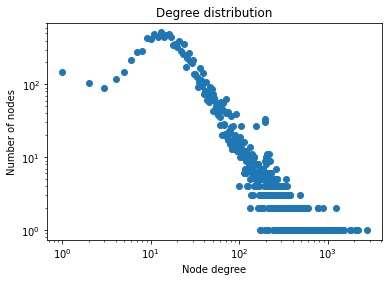

In [144]:
plotDegreeDistr(G_org)